<div class="head0">
    <div class="head0__name">
        Diffusion equation with zero drift in 1D case
    </div>
    <div class="head0__note">
        Solution of the 1D Fokker-Planck equation by fast and accurate tensor based method.
    </div>
</div>

In [1]:
import sys
import time

import numpy as np
import scipy.sparse as sp
from scipy.linalg import expm as expm
import matplotlib.pyplot as plt

sys.path.extend(['./../lib', './../helpers'])
from intertrain import Intertrain
from solver import Solver as Solver

from helpers import init_jupyter; init_jupyter()

Start |  5:27PM MSK on Sep 03, 2019 |
-------------------------------------


<div class="head1">
    <div class="head1__name">
        Model problem
    </div>
</div>

Consider 1D equation with zero drift
$$
    dx = d\beta,
    \quad
    \frac{\partial \rho}{\partial t} = D \Delta \rho,
    \quad
    \rho(x, 0) = \rho_0(x),
$$
where
$$
    x \in \Omega = [-5, 5],
    \quad
    \rho(x, t) |_{\partial \Omega} \approx 0,
    \quad
    \rho_0(x) = \frac{1}{\sqrt{2 \pi s}}\exp{\left[-\frac{x^2}{2s}\right]},
    \quad
    s = 1,
    \quad
    D = 1,
$$
with known analytic solution
$$
    \rho(x, t) =
        \frac
            {
                1
            }
            {
                \sqrt{2 \pi s + 4 \pi D t}
            }
        \exp{ \left[
            - \frac
                {
                    x^2
                }
                {
                    2  s + 4 D t
                }
        \right] },
$$
with the zero stationary ($t \rightarrow \infty$) solution.

In [2]:
s = 1.
Dc = 1. # Should be 1. for explicit solvers

def func_f0(x, t):
    return np.zeros(x.shape)

def func_f1(x, t):
    return np.zeros(x.shape)

def func_r0(x):
    r = np.exp(-1. * x*x / (2. * s))
    r/= np.sqrt(2. * np.pi * s)
    return r.reshape(-1)

def func_rt(x, t):
    r = np.exp(-1. * x*x / (2. * s + 4. * Dc * t))
    r/= np.sqrt(2. * np.pi * s + 4. * np.pi * Dc * t)
    return r.reshape(-1)

def func_rs(x):
    r = np.zeros(x.shape)
    return r.reshape(-1)

def show_x(X, r_calc, _time):
    X = X.reshape(1, -1)
    r_real = func_rt(X.reshape(1, -1), t_max)
    e = np.linalg.norm(r_real - r_calc) / np.linalg.norm(r_real)

    plt.plot(
        X.reshape(-1), r_calc, label='Calculated',
        linewidth=1, color='tab:green', marker='o', markersize=7,
        markerfacecolor='lightgreen', markeredgecolor='g'
    )
    plt.plot(
        X.reshape(-1), r_real, label='Analytic',
        linewidth=3, color='black'
    )
    plt.title('Solution at final time step')
    plt.xlabel('x')
    plt.ylabel('r')
    plt.legend(loc='best')
    plt.show()

    print('Number of spatial points : %8d'%x_poi)
    print('Number of time points    : %8d'%t_poi)
    print('Error (relative norm)    : %-12.2e'%e)
    print('Total time (sec)         : %-12.2e'%_time)

In [3]:
t_poi = 1000
t_min = 0.
t_max = 1.

x_poi = 61
x_min = -5.
x_max = +5.

m = t_poi
n = x_poi
l = (x_max - x_min) / x_poi
h = (t_max - t_min) / (t_poi - 1)
T = np.linspace(t_min, t_max, t_poi)

print('Time-space factor (h/l^2) : %-8.5f'%(h/l/l))

Time-space factor (h/l^2) : 0.03725 


<div class="head1">
    <div class="head1__name">
        Explicit solution 1
    </div>
    <div class="head1__note">
        Forward Euler scheme and uniform spatial grid (only for example)
    </div>
</div>

We can solve it on the uniform spatial grid for the time $t > 0$ using standard forward Euler scheme
$$
    r_{k+1} = r_{k} + h D r_{k},
    \quad
    k = 0, 1, \ldots, m-1,
$$
where
$$
    D = \frac{1}{l^2} tridiag \left( 1, -2, 1 \right).
$$

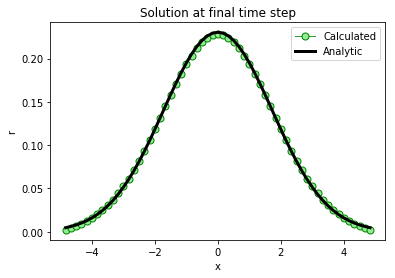

Number of spatial points :       61
Number of time points    :     1000
Error (relative norm)    : 9.86e-03    
Total time (sec)         : 6.34e-03    


In [4]:
_time = time.time()

X = np.linspace(x_min, x_max, x_poi).reshape(1, -1)[:, 1:-1]
D = sp.spdiags([[1.]*x_poi, [-2.]*x_poi, [1.]*x_poi], [-1, 0, 1], x_poi, x_poi).tocsr() 
D = (D / l / l).toarray()
Z = h * D[1:-1, 1:-1]

r = func_r0(X)
for t in T[1:]:
    r = r + Z @ r

show_x(X, r, time.time() - _time)

<div class="head1">
    <div class="head1__name">
        Explicit solution 2
    </div>
    <div class="head1__note">
        Backward Euler scheme and uniform spatial grid (only for example)
    </div>
</div>

We can solve it on the uniform spatial grid for the time $t > 0$ using standard backward Euler scheme
$$
    A r_{k+1} = r_{k},
    \quad
    k = 0, 1, \ldots, m-1,
$$
where
$$
    A = tridiag \left( -F, 1+2F, -F \right),
    \quad
    F = \frac{h}{l^2}.
$$

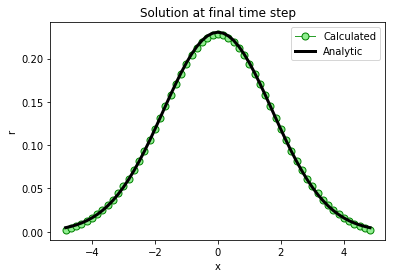

Number of spatial points :       61
Number of time points    :     1000
Error (relative norm)    : 9.64e-03    
Total time (sec)         : 6.02e-02    


In [5]:
_time = time.time()

F = h / l / l
X = np.linspace(x_min, x_max, x_poi).reshape(1, -1)[:, 1:-1]
D = sp.spdiags([[-F]*x_poi, [1. + 2. * F]*x_poi, [-F]*x_poi], [-1, 0, 1], x_poi, x_poi).tocsr().toarray()
Z = D[1:-1, 1:-1]

r = func_r0(X)
for t in T[1:]:
    r = np.linalg.solve(Z, r)

show_x(X, r, time.time() - _time)

<div class="head1">
    <div class="head1__name">
        Explicit solution 3
    </div>
    <div class="head1__note">
        Matrix exponential and uniform spatial grid (only for example)
    </div>
</div>

We can solve it on the uniform spatial grid for the time $t > 0$ using matrix exponential and the 2th order finite difference matrix
$$
    u_{t} = e^{t \cdot D} u_{0},
$$
where $u_{0}(x)$ is the known initial condition.

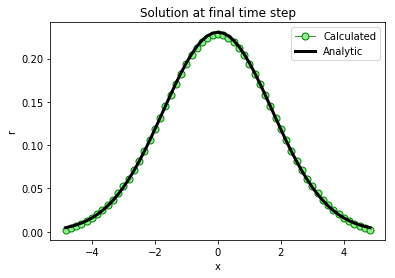

Number of spatial points :       61
Number of time points    :     1000
Error (relative norm)    : 9.75e-03    
Total time (sec)         : 9.93e-03    


In [6]:
_time = time.time()

X = np.linspace(x_min, x_max, x_poi).reshape(1, -1)[:, 1:-1]
D = sp.spdiags([[1.]*x_poi, [-2.]*x_poi, [1.]*x_poi], [-1, 0, 1], x_poi, x_poi).tocsr() 
D = (D / l / l).toarray()
Z = expm((t_max - t_min) * D[1:-1, 1:-1])
r = Z@func_r0(X)

show_x(X, r, time.time() - _time)

<div class="head1">
    <div class="head1__name">
        Explicit solution 4
    </div>
    <div class="head1__note">
        Matrix exponential and Chebyshev spatial grid (only for example)
    </div>
</div>

We can solve it on the Chebyshev spatial grid for the time $t > 0$ using matrix exponential and the 2th order Chebyshev differentiation matrix
$$
    u_{t} = e^{t \cdot D} u_{0},
$$
where $u_{0}(x)$ is the known initial condition.

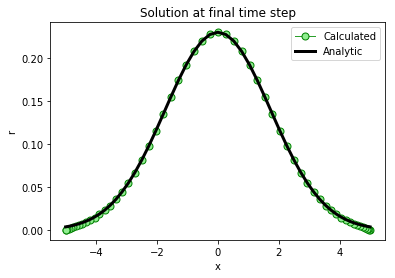

Number of spatial points :       61
Number of time points    :     1000
Error (relative norm)    : 1.45e-02    
Total time (sec)         : 4.47e-03    


In [7]:
_time = time.time()

IT = Intertrain(n=[x_poi], l=[[x_min, x_max]])
X = IT.grid()[:, 1:-1]
D = IT.dif2()
Z = expm((t_max - t_min) * D[1:-1, 1:-1])
r = Z@func_r0(X)

show_x(X, r, time.time() - _time)

<div class="head1">
    <div class="head1__name">
        Solution by the solver
    </div>
    <div class="head1__note">
        Since interpolation is not required for the case $f \equiv 0$, but our solver calculates it by design, then it is expected to operate much slower than explicit (expm) simple solver, which was presented above.
    </div>
</div>

In [8]:
SL = Solver(d=1)
SL.set_grid_t(t_poi, t_min, t_max, t_hst=10)
SL.set_grid_x(x_poi, x_min, x_max)
SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
SL.set_coefs(Dc)

SL.prep()
SL.calc()

Solve: 100%|█| 999/999 [00:01<00:00, 509.03step/s, | At T = 1.00e+00 : error = 1.58e-02]


In [9]:
SL.info()

----------- Solver
Format    : 1D, NP [order=1]
Grid x    : poi =        61, min =   -5.0000, max =    5.0000
Grid t    : poi =      1000, min =    0.0000, max =    1.0000 , hst =        10
Time sec  : prep = 7.45e-03, calc = 1.91e+00, spec = 1.57e+09
Rel.err.  : 1.58e-02


<div class="head2">
    <div class="head2__name">
        Solution near boundaries
    </div>
    <div class="head2__note">
        Solution is zero near the boundaries as expected, but real values are not equal to zero.
    </div>
</div>

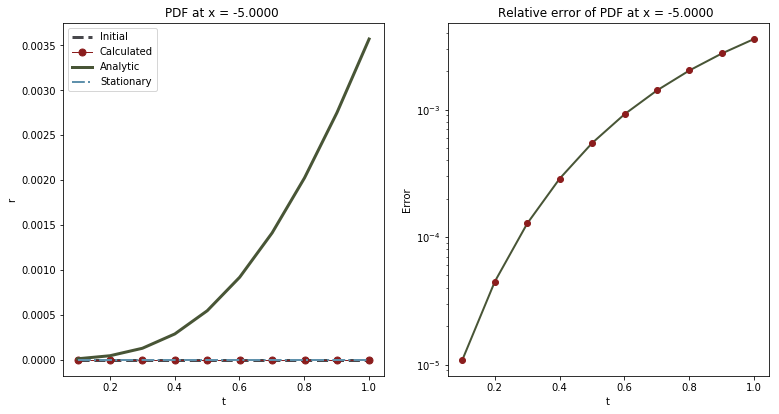

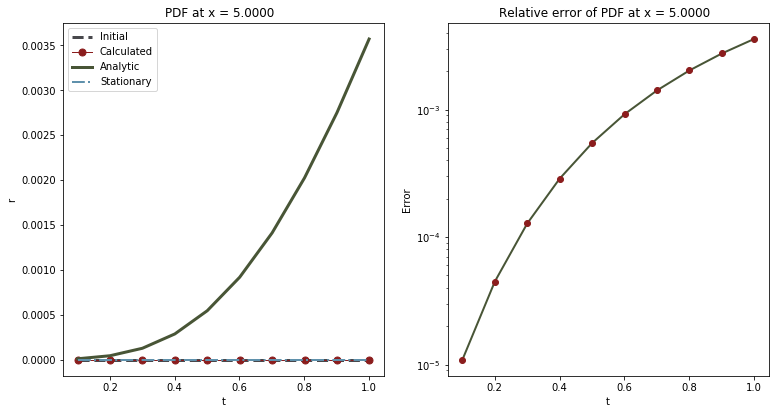

In [10]:
SL.plot_t(x=x_min)
SL.plot_t(x=x_max)

<div class="head2">
    <div class="head2__name">
        Solution in the inner points
    </div>
    <div class="head2__note">
        Solution is very accurate.
    </div>
</div>

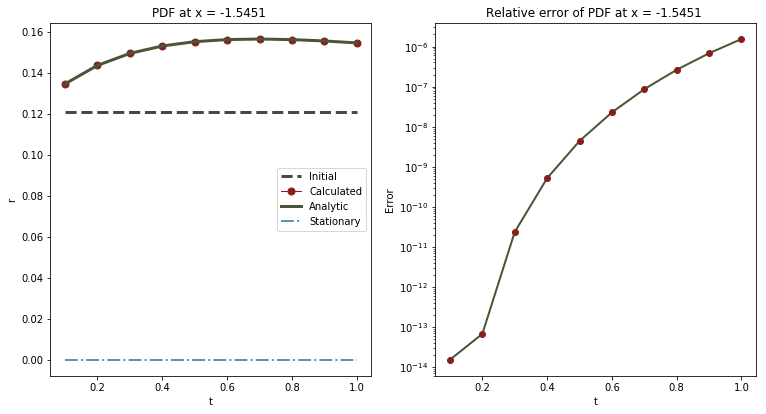

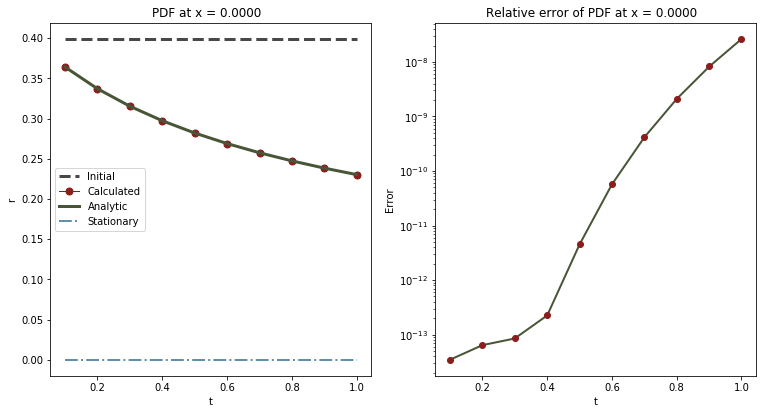

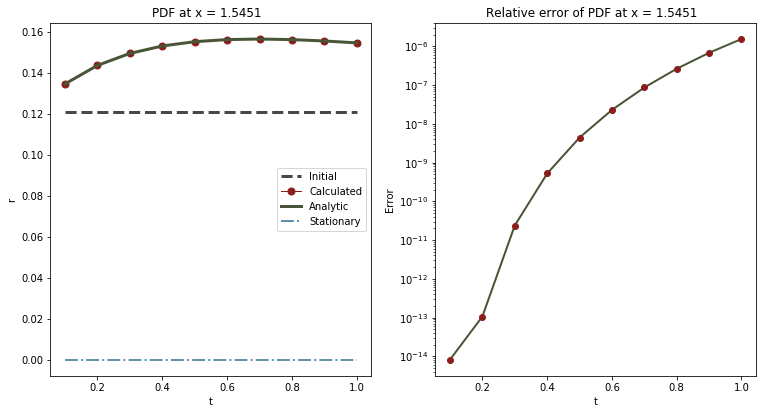

In [11]:
SL.plot_t(x=-1.5)
SL.plot_t(x=+0.0)
SL.plot_t(x=+1.5)

<div class="head2">
    <div class="head2__name">
        Solution for different time steps
    </div>
    <div class="head2__note">
        Solution is very accurate.
    </div>
</div>

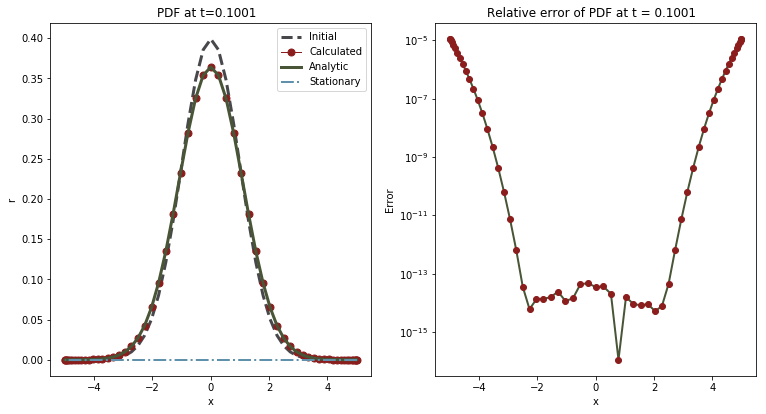

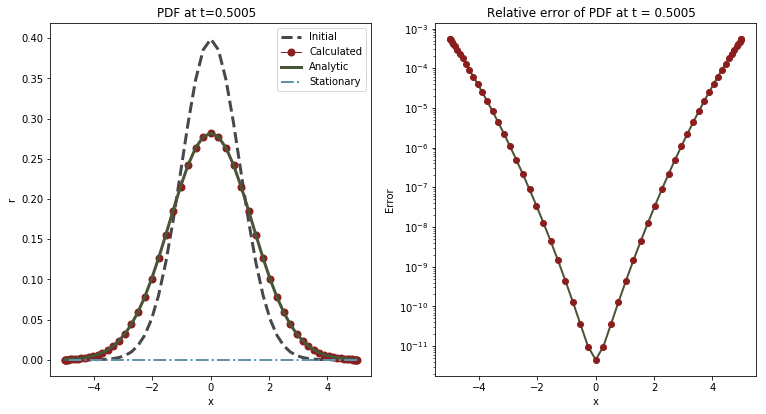

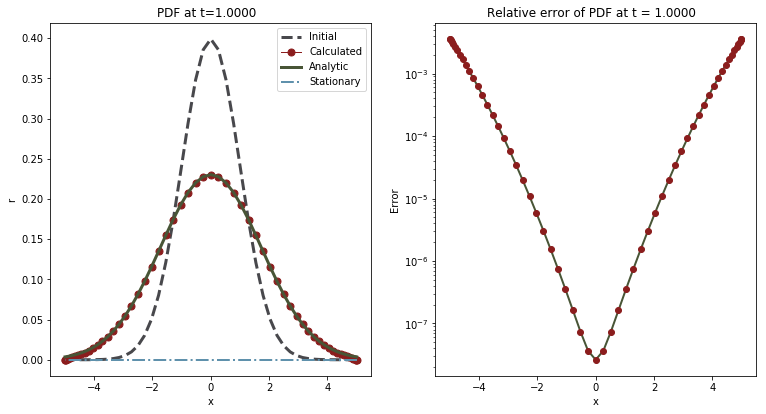

In [12]:
SL.plot_x(t=0.1)
SL.plot_x(t=0.5)
SL.plot_x()

<div class="head1">
    <div class="head1__name">
        Accuracy vs number of spatial points
    </div>
    <div class="head1__note">
        Note that analytic solution is small but not zero at boundaries, hence the integral (norm) error is not small for any grid size.
    </div>
</div>

In [19]:
m = 1000
N = [10, 50, 100, 200]
Times = []
Errors = []

for n in N:
    SL = Solver(d=1)
    SL.set_grid_t(m, t_min, t_max, t_hst=1)
    SL.set_grid_x(n, x_min, x_max)
    SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SL.set_coefs(Dc)
    SL.prep()
    SL.calc()
    Times.append([SL._t_prep, SL._t_calc, SL._t_spec])
    Errors.append(SL._err)

Solve: 100%|█| 999/999 [00:07<00:00, 132.08step/s, | At T = 1.00e+00 : error = 1.53e-02]


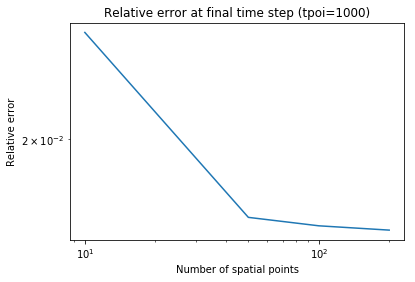



Solver info for n = 200, m = 1000 : 
----------- Solver
Format    : 1D, NP [order=1]
Grid x    : poi =       200, min =   -5.0000, max =    5.0000
Grid t    : poi =      1000, min =    0.0000, max =    1.0000 , hst =         1
Time sec  : prep = 4.06e-02, calc = 7.49e+00, spec = 1.57e+09
Rel.err.  : 1.53e-02


In [20]:
plt.plot(N, Errors)
plt.semilogx()
plt.semilogy()
plt.title('Relative error at final time step (tpoi=%d)'%m)
plt.xlabel('Number of spatial points')
plt.ylabel('Relative error')
plt.show()

print('\n\nSolver info for n = %d, m = %d : '%(N[-1], m))
SL.info()

<div class="head1">
    <div class="head1__name">
        Accuracy vs number of time points
    </div>
    <div class="head1__note">
        Note that analytic solution is small but not zero at boundaries, hence the integral (norm) error is not small for any grid size.
    </div>
</div>

In [21]:
M = [10, 100, 1000, 5000, 10000]
n = 100
Times = []
Errors = []

for m in M:
    SL = Solver(d=1)
    SL.set_grid_t(m, t_min, t_max, t_hst=1)
    SL.set_grid_x(n, x_min, x_max)
    SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SL.set_coefs(Dc)
    SL.prep()
    SL.calc()
    Times.append([SL._t_prep, SL._t_calc, SL._t_spec])
    Errors.append(SL._err)

Solve: 100%|█| 9999/9999 [00:34<00:00, 289.02step/s, | At T = 1.00e+00 : error = 1.55e-02]


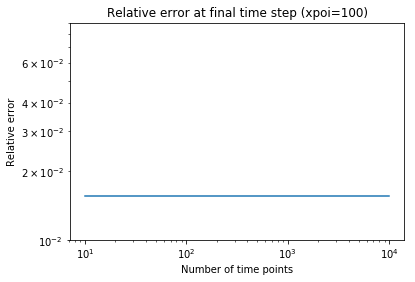



Solver info for n = 100, m = 10000 : 
----------- Solver
Format    : 1D, NP [order=1]
Grid x    : poi =       100, min =   -5.0000, max =    5.0000
Grid t    : poi =     10000, min =    0.0000, max =    1.0000 , hst =         1
Time sec  : prep = 7.65e-03, calc = 3.43e+01, spec = 1.57e+09
Rel.err.  : 1.55e-02


In [27]:
plt.plot(M, Errors)
plt.semilogx()
plt.semilogy()
plt.ylim(1.E-2, 9.E-2)
plt.title('Relative error at final time step (xpoi=%d)'%n)
plt.xlabel('Number of time points')
plt.ylabel('Relative error')
plt.show()

print('\n\nSolver info for n = %d, m = %d : '%(n, M[-1]))
SL.info()

<div class="head1">
    <div class="head1__name">
        Conclusion
    </div>
    <div class="head1__note">
        As we can see, for diffusion process without drift term our solver works absolutely correct but rather slow. Since analytic solution is small but not zero at boundaries, the integral (norm) error is not small for any grid size, but at selected points (far from the border) we have very accurate solution (relative error is about $10^{-8})$.
    </div>
    </div>
</div>

<div class="end"></div>